### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.

### 2. Подберите параметры модели SARIMAX для этого ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import itertools

import warnings

Загрузим данные

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Построим график

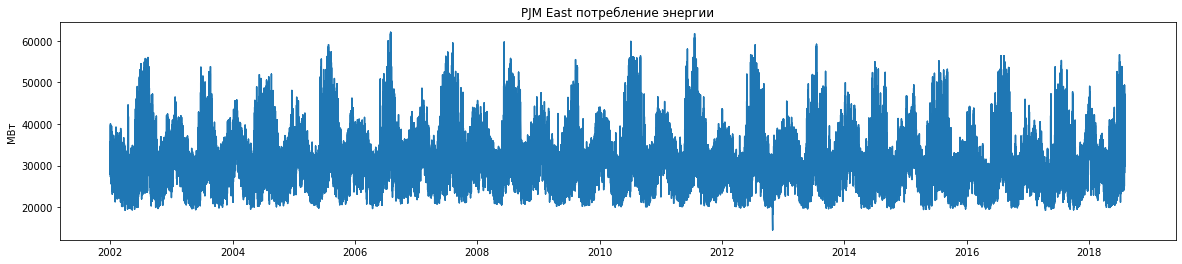

In [3]:
plt.figure(figsize =(20,4))
plt.plot(data.index, data['PJME_MW'])
plt.title('PJM East потребление энергии')
plt.ylabel ('МВт')
plt.show()

Сделаем ресемплинг данных по месяцам.

In [4]:
data_m = data.resample('M').mean()

In [5]:
data_m.shape

(200, 12)

Построим ACF и PACF для того чтобы посмотреть на сезонность.

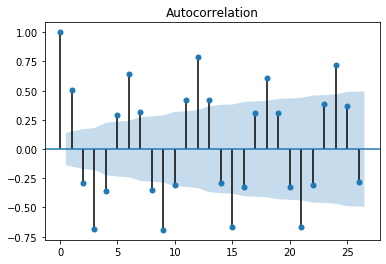

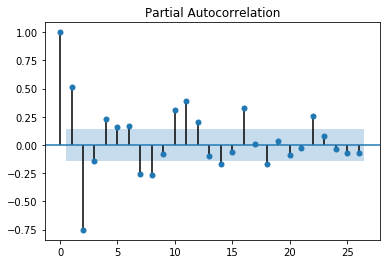

In [6]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

Видим, что есть сильная корреляция для квартальных лагов в 3, 6, 9 и 12 месяцев, но самая большая в 12 месяцев. Это значение и будем использовать в модели сезонности, т.к. сезоны явно видны на графике ACF.

Подберем лучшие параметры для SARIMAX. Метрикой будет являться критерий Акаике (AIC). Чем меньше, тем лучше.

In [7]:
# Определим p, d и q в диапазоне 0-3
p = q = range(0, 3)
d = [0, 1]

# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

# зададим сетку сезонности
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [8]:
warnings.filterwarnings("ignore") # отключает предупреждения
aic = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            aic[results.aic] = [param, param_seasonal, results]
        except:
            continue
min_aic = min(aic)
results = aic[min_aic][2]
print(f'SARIMA{aic[min_aic][0]}x{aic[min_aic][1]} - AIC:{min_aic}')

SARIMA(0, 1, 2)x(1, 1, 2, 12) - AIC:2606.3201811571607


### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Посмотрим на автокорреляцию для остатков ряда модели с лучшими параметрами.
ARIMA(0, 1, 2)x(1, 1, 2, 12) - AIC:2606.3201811571607

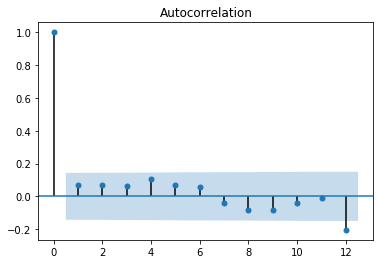

In [9]:
sm.graphics.tsa.plot_acf(results.resid, lags=12)
plt.show()

Видим, что значительной корреляции нет. Это означает, что наша модель удовлетворительна.

Оценим близости распределений остатков модели к нормальному закону.

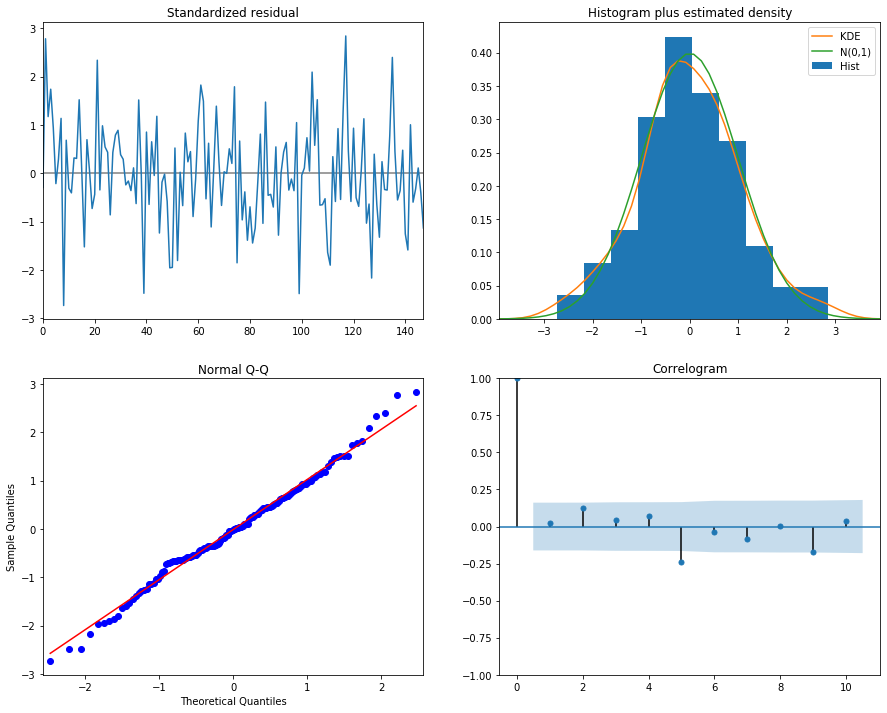

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Эти графики так же подтверждают, что наша модель удовлетворительна и распределение остатков близко к нормальному.

Проведем моделирование прогноза на основе найденой SARIMA(0, 1, 2)x(1, 1, 2, 12) для последних 12 дней(и предсказание следующих 30) и сравним их с фактом.

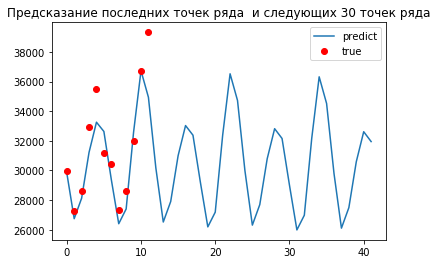

In [11]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )

#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

В целом модель SARIMA на ресемплинге по месяцам дает лучшие прогнозы по сравнению с ресемплингом по неделям. Это связано с тем, то при ресемплинге по месяцам получаются более сглаженные данные с более выраженной и однородной сезонностью.

### 4. Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

Прочитаем данные.

In [12]:
brent_data = pd.read_csv('my_BRENT2019.csv',sep = ',', index_col=[0], parse_dates=[0])

Сделаем ресемплинг данных по неделям.

In [13]:
brent_data_w = brent_data.resample('W').mean()

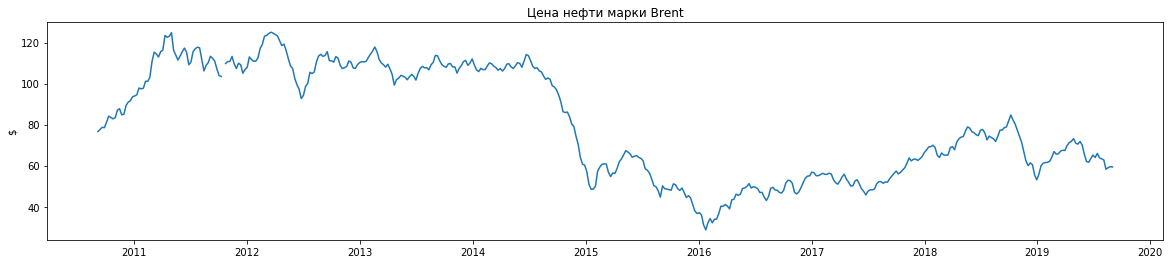

In [14]:
plt.figure(figsize =(20,4))
plt.plot(brent_data_w.index, brent_data_w['Значение'])
plt.title('Цена нефти марки Brent')
plt.ylabel ('$')
plt.show()

Построим ACF и PACF. Посмотрим данные за 3 месяца, т.е. 12 недель.

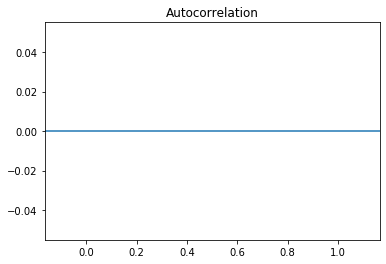

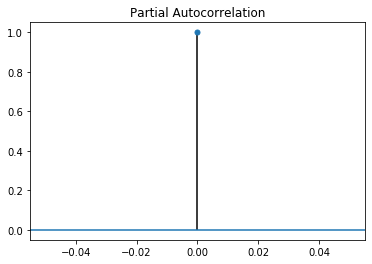

In [15]:
sm.graphics.tsa.plot_acf(brent_data_w['Значение'].values, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(brent_data_w['Значение'].values, lags=12)
plt.show()

Удивительно, но ACF и PACF по недельным данным не строится. Проверял и на узком интервале дат и на полном. Автокорреляция нормально отображается только на данных без ресемплинга или месячному и годовому.

Подберем лучшие параметры для модели.

In [16]:
# Определим p, d и q в диапазоне 0-3
p = q = range(0, 3)
d = [0, 1]

# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))


warnings.filterwarnings("ignore")
aic = {}
for param in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'].values[:-12],
                                        order=param,
                                        trend='ct',
                                        seasonal_order=[0, 0, 0, 0],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        aic[results.aic] = [param, results]
    except:
        continue
min_aic = min(aic)
results = aic[min_aic][1]
print(f'ARIMA{aic[min_aic][0]} - AIC:{min_aic}')

ARIMA(0, 1, 2) - AIC:1975.2208486742572


### 5. Оцените результат моделирования
Посмотрим на автокорреляцию остатков.

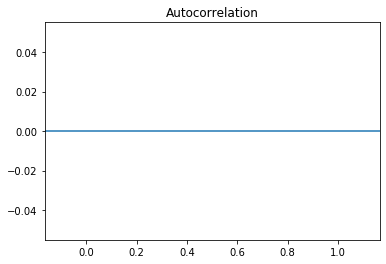

In [17]:
sm.graphics.tsa.plot_acf(results.resid, lags=12)
plt.show()

Автокорреляция осталась неизменной по непонятной мне причине.
Визуализируем наш прогноз.

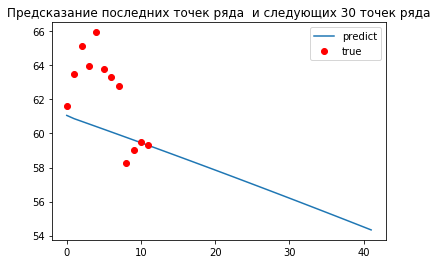

In [18]:
pred_dynamic = results.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )

#Отобразим истинный значения 
plt.plot(brent_data_w['Значение'].values[-12:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

Видно, что наша модель плохо справляется с прогнозами и похожа на обычную регрессионную прямую. Я дополнительно провел такой же анализ для данных с месячным ресемплингом и наша модель так же отработала плохо.